In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import random
import cv2
import regex as re
from tensorflow import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
IMAGE_WIDTH=80
IMAGE_HEIGHT=80
IMAGE_CHANNELS=3
IMAGE_SIZE= (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)
BATCH_SIZE = 128
EPOCHS = 10

PATH

In [3]:
path = os.getcwd()[:-9]

In [4]:
train_path = path + "\\clips-data\\train"
test_path = path + "\\clips-data\\test"
solution_path = path + "\\clips-data\\solution"

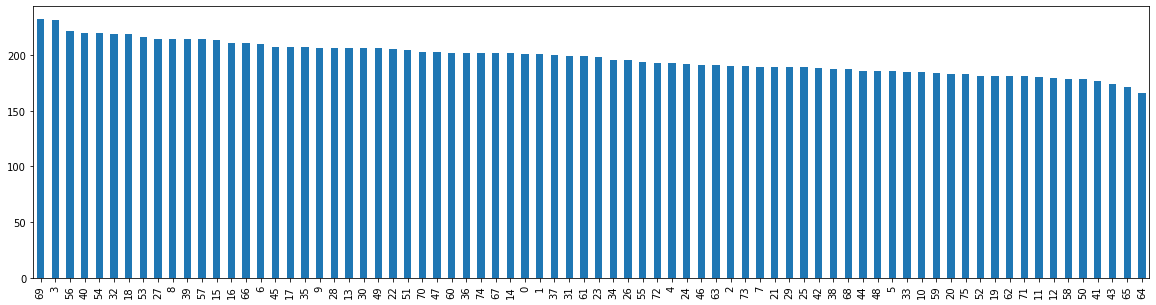

In [26]:
plt.figure(figsize=(20, 5))
df_train = pd.read_csv(path+ "\\train.csv")
df_train["clip_count"].value_counts().plot.bar();

In [6]:
print(np.max(df_train["clip_count"]))
print(df_train["clip_count"].nunique())

75
76


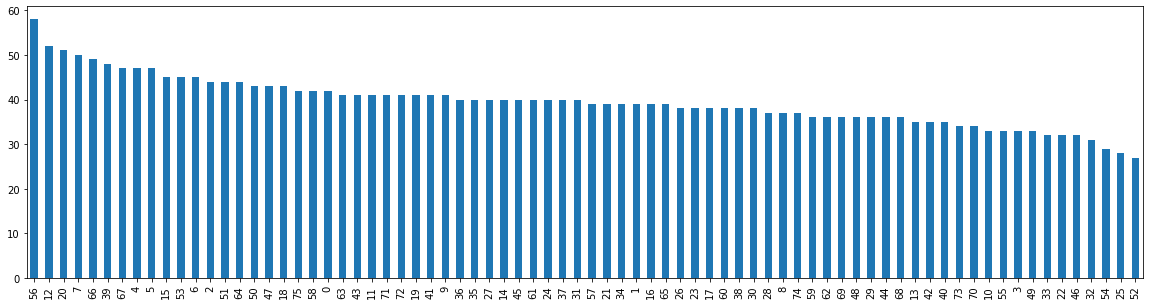

In [27]:
plt.figure(figsize=(20, 5))
df_test = pd.read_csv(path+"\\test.csv")
df_test["clip_count"].value_counts().plot.bar();

In [8]:
print(np.max(df_test["clip_count"]))
print(df_test["clip_count"].nunique())

75
76


In [9]:
df_train

,id,clip_count
0,30001,11
1,30002,2
2,30003,26
3,30004,41
4,30005,49
...,...,...
14995,44996,29
14996,44997,1
14997,44998,57
14998,44999,53


42732
(256, 256, 4)
255


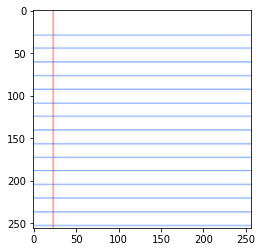

In [7]:
random_index = random.choice(df_train.id.values)
print(random_index)
image = imread(train_path + "\\clips-" + str(random_index) + ".png\\")

print(image.shape)
print(np.max(image))
plt.imshow(image);

(256, 256, 3)


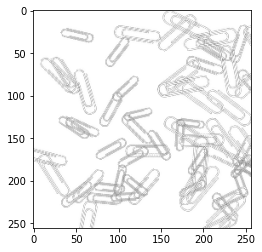

In [9]:
cyan, magenta, yellow, black = cv2.split(image)
img_not_compressed =cv2.merge([black, black, black, black])
image2 = cv2.cvtColor(img_not_compressed, cv2.COLOR_BGR2RGB)
print(image2.shape)
plt.imshow(image2);

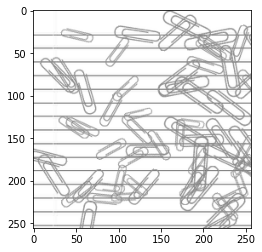

In [10]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
b, g, r = cv2.split(image)
img_not_compressed = cv2.merge([r, r, r])
plt.imshow(img_not_compressed);

(80, 80)


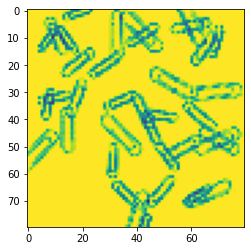

In [26]:
img_not_compressed = cv2.merge([black])
smallimage = cv2.resize(img_not_compressed, (80, 80))  
print(smallimage.shape)
#viewing the not compressed image
plt.imshow(smallimage);

In [30]:
def read_data(path, size, df):
    df = df.set_index("id")
    file_folders = os.listdir(path)
    X = []
    Y = []    
    for imagen in file_folders:
        re1 = str(re.findall("-([\d]+).", imagen))
        image = imread(path + "\\" + imagen)        
        cyan, magenta, yellow, black = cv2.split(image)
        img_not_compressed =cv2.merge([black, black, black, black])
        image2 = cv2.cvtColor(img_not_compressed, cv2.COLOR_BGR2RGB)
        smallimage = cv2.resize(image2, (size, size))            

        X.append(smallimage)
        Y.append(df.loc[int(re1[2:-2]), "clip_count"])

    return np.array(X), np.array(Y)

X_train, y_train = read_data(train_path, IMAGE_WIDTH, df_train)
X_test, y_test = read_data(test_path, IMAGE_WIDTH, df_test)
print(X_train.shape)
print(X_test.shape)

(15000, 80, 80, 3)
(3000, 80, 80, 3)


(80, 80, 3)


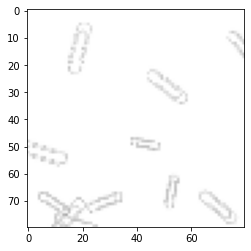

In [31]:
print(X_train[0].shape)
plt.imshow(X_train[25]);

In [32]:
print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 123
Max: 255


In [33]:
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Min:", np.min(X_train))
print("Max:", np.max(X_train))

Min: 0.4823529411764706
Max: 1.0


In [42]:
np.savez(os.getcwd() + "/arrays_train_tedst.npz", 
            X_train = X_train,
            y_train = y_train,
            X_test = X_test,
            y_test = y_test)

In [5]:
data = np.load(os.getcwd() + "/arrays_train_tedst.npz")
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

MODELO

In [6]:
layers = [
    keras.layers.Conv2D(64, (3, 3), activation ='relu', input_shape = (80, 80, 3)),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation ='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation ='relu'),
    keras.layers.Dense(1, activation = "linear"),

]

model = keras.Sequential(layers)

model.compile(optimizer = "Adamax",
            loss = "mean_squared_error",
            metrics = ["mse", tf.keras.metrics.RootMeanSquaredError()])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 20736)             0         
                                                                 
 dense (Dense)               (None, 128)               2

In [7]:
data = np.load(path + '/arrays_train_test.npz')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [8]:
earlystop = EarlyStopping(monitor = "val_loss" , patience=5)
checkpoint = ModelCheckpoint("check_point_mode.h5")

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
history = model.fit(X_train, 
                    y_train,
                    epochs = 30,
                    validation_split = 0.1,
                   callbacks=[earlystop])

Epoch 1/30
422/422 [==============================] - 9s 14ms/step - loss: 181.0106 - mse: 181.0106 - root_mean_squared_error: 13.4540 - val_loss: 17.0321 - val_mse: 17.0321 - val_root_mean_squared_error: 4.1270
Epoch 2/30
422/422 [==============================] - 5s 13ms/step - loss: 15.9770 - mse: 15.9770 - root_mean_squared_error: 3.9971 - val_loss: 10.0898 - val_mse: 10.0898 - val_root_mean_squared_error: 3.1764
Epoch 3/30
422/422 [==============================] - 5s 13ms/step - loss: 12.5094 - mse: 12.5094 - root_mean_squared_error: 3.5369 - val_loss: 15.1232 - val_mse: 15.1232 - val_root_mean_squared_error: 3.8889
Epoch 4/30
422/422 [==============================] - 5s 13ms/step - loss: 11.8206 - mse: 11.8206 - root_mean_squared_error: 3.4381 - val_loss: 10.9717 - val_mse: 10.9717 - val_root_mean_squared_error: 3.3124
Epoch 5/30
422/422 [==============================] - 5s 13ms/step - loss: 11.0283 - mse: 11.0283 - root_mean_squared_error: 3.3209 - val_loss: 11.2066 - val_mse

In [11]:
model.save("NNC1_80x80.h5")

In [6]:
model = keras.models.load_model("NNC1_80x80.h5")

In [10]:
results = model.evaluate(X_test, y_test)
results

94/94 [==============================] - 1s 6ms/step - loss: 5.3397 - mse: 5.3397 - root_mean_squared_error: 2.3108


[5.339706897735596, 5.339706897735596, 2.3107805252075195]

In [11]:
df_history = pd.DataFrame(history.history)
df_history["epoch"] = history.epoch
df_history

,loss,mse,root_mean_squared_error,val_loss,val_mse,val_root_mean_squared_error,epoch
0,181.010590,181.010590,13.454018,17.032135,17.032135,4.127001,0
1,15.977021,15.977021,3.997127,10.089808,10.089808,3.176446,1
2,12.509411,12.509411,3.536865,15.123215,15.123215,3.888858,2
3,11.820637,11.820637,3.438115,10.971664,10.971664,3.312350,3
4,11.028332,11.028332,3.320893,11.206638,11.206638,3.347632,4
5,10.439848,10.439848,3.231075,6.981596,6.981596,2.642271,5
6,10.734699,10.734699,3.276385,23.612547,23.612547,4.859274,6
7,10.960527,10.960527,3.310669,6.364161,6.364161,2.522729,7
8,11.171889,11.171889,3.342438,7.020145,7.020145,2.649556,8
9,10.411077,10.411077,3.226620,10.753205,10.753205,3.279208,9


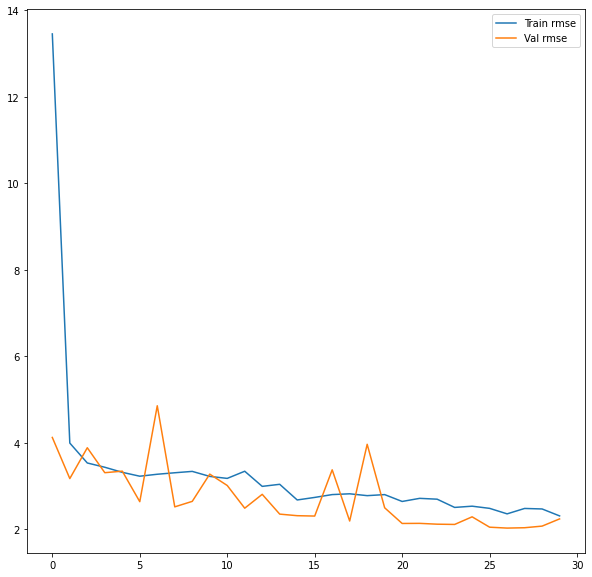

In [12]:
plt.figure(figsize=(10, 10))
plt.plot(df_history["epoch"], df_history["root_mean_squared_error"],  label = "Train rmse")
plt.plot(df_history["epoch"], df_history["val_root_mean_squared_error"], label = "Val rmse")
plt.legend();

In [13]:
sample = pd.read_csv(path+"\\sample_submission.csv")
sample.tail(20)

,id,clip_count
1980,49981,58
1981,49982,57
1982,49983,48
1983,49984,29
1984,49985,70
1985,49986,45
1986,49987,82
1987,49988,29
1988,49989,93
1989,49990,37


In [14]:
def read_data(path, size):
    file_folders = os.listdir(path)
    X = []
    id = []    
    for imagen in file_folders:
        re1 = str(re.findall("-([\d]+).", imagen))
        image = imread(path + "\\" + imagen)

        cyan, magenta, yellow, black = cv2.split(image)
        img_not_compressed =cv2.merge([black, black, black, black])
        image2 = cv2.cvtColor(img_not_compressed, cv2.COLOR_BGR2RGB)
        smallimage = cv2.resize(image2, (size, size))            

        X.append(smallimage)
        id.append(int(re1[2:-2]))

    return np.array(X), np.array(id)

X, id = read_data(solution_path, IMAGE_WIDTH)
# X_test, y_test = read_data(test_path, IMAGE_WIDTH, df_test)
# print(X_train.shape)
# print(X_test.shape)

In [15]:
print(X.shape)

(2000, 80, 80, 3)


In [16]:
len(id)

2000

In [27]:
print("Min:", np.min(X))
print("Max:", np.max(X))

Min: 120
Max: 255


In [17]:
X = X / 255.0

print("Min:", np.min(X))
print("Max:", np.max(X))

Min: 0.47058823529411764
Max: 1.0


In [18]:
predictions = model.predict(X)

In [19]:
predictions

array([[27.476345],
       [30.000317],
       [36.171856],
       ...,
       [73.938896],
       [20.164383],
       [33.30311 ]], dtype=float32)

In [21]:
predictions[9]

array([4.212623], dtype=float32)

In [22]:
predicions_reshape = predictions.reshape(2000,)

In [23]:
submission = pd.DataFrame({"id":id, "clip_count":predicions_reshape})
submission

,id,clip_count
0,48001,27.476345
1,48002,30.000317
2,48003,36.171856
3,48004,14.248414
4,48005,39.916813
...,...,...
1995,49996,33.912354
1996,49997,54.195629
1997,49998,73.938896
1998,49999,20.164383


In [24]:
import urllib
from PIL import Image
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.id.all() == sample.id.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://i.kym-cdn.com/photos/images/facebook/000/747/556/27a.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Clara: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `diamonds_test.csv`. Lloro.")

In [25]:
chequeator(submission)

You're ready to submit!


In [26]:
submission["clip_count"] = submission["clip_count"].astype(int)

In [27]:
submission

,id,clip_count
0,48001,27
1,48002,30
2,48003,36
3,48004,14
4,48005,39
...,...,...
1995,49996,33
1996,49997,54
1997,49998,73
1998,49999,20


In [28]:
import urllib
from PIL import Image
def chequeator2(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.id.all() == sample.id.all():
                print("You're ready to submit!")
                submission.to_csv("submission_round.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://i.kym-cdn.com/photos/images/facebook/000/747/556/27a.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Clara: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `diamonds_test.csv`. Lloro.")

In [29]:
chequeator2(submission)

You're ready to submit!


In [113]:
model.save("NNC1_80x80.h5")